# Final use-case : School Failure Prediction

This notebook will try to build a **predictive ai solution** to estimate a school failure for a given student.

The system use a "*Chain of Responsibiliy*" pattern to pipeline the process. Each element of the chain is responsible of one process, then give the result to the other.

This architecture allow to easily change or add process orchestration.

In [148]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from loguru import logger

from core.pipeline_core.pipeline_core import DataHandler, PipelineContext, PipelineOrchestrator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


*Refactorization*
Handlers are removed from the book :
- DataLoader is now in the core.handlers package (data_loader.py),
- SensitiveDataHandler moved to core.handlers package (sensitive_data_handler.py)
- MergerHandler moved to core.handlers package (merger_handler.py)
- OutlierHandler moved to core.handlers package (outlier_handler.py)
- ImputationHandler moved to core.handlers package (imputation_handler.py)
- DataExportHandler moved to core.handlers package (data_export_handler.py),
- ModelHandler moved to core.handlers package (model_handler.py)

**Notes** :

*Outlier handler :*
Handle *outliers* using strategies :
- IQR,
- Isolation Forest
Finally removes the entire line if one cols is ludicurious

*NaN imputation :*
Identity NaN values from the dataframe. Use different strategies for replacement :
- AIImputation : Using regression to identify NaN (usefull for large dataframe)
- SimpleImputer : Using either mean or median replacement strategy

*Model Handler* :
ModelHandler use *strategies*: 
- Logistic Regression - LR,
- Random Forest Classifier - RF 

and use 4 base hypothesis : full_dataframe, no sensitive data, no_g1, no_g1_g2

The pipeline scheme sets in a YAML config can be tuned to :
- Add other algorithms,
- Sets different hypothesis

During training MLFlow is used to store parameters, artifacts and final models.

## Move orchestration logic to YAML configuration
Using configuration, we offer the possibility to handle steps dynamically. The following class read configuration and build the orchestration.

**PipelineBuilder** moved to core.pipeline_core package (pipeline_builder.py)

## Orchestrator settings (@Deprecated)
- Sets sources,
- Sets sensitive datas,
- Initiate orchestrator

**Deprecated** after delegating to PiplelineBuilder, there's no need to manually configure the orchestrator.

Kept only here for documentation

In [149]:
from core.handlers.data_export_handler import DataExportHandler
from core.handlers.data_loader import DataLoader
from core.handlers.imputation_handler import ImputationHandler
from core.handlers.merger_handler import MergerHandler
from core.handlers.model_handler import ModelHandler
from core.handlers.outlier_handler import OutlierHandler
from core.handlers.sensitive_data_handler import SensitiveDataHandler
from core.strategy_core.outliers_strategies import IsolationForestStrategy
from core.strategy_core.imputation_strategies import AIImputationStrategy

files_to_load = {
    "maths": "datas/student-mat.csv",
    "por": "datas/student-por.csv"
}

sensitives = [
    "romantic", # No correlation
    "Dalc", # Discriminant data, cannot be used
    "Walc", # Discrimant data, cannot be used
]

# Make chain instances :
# 1. Data processing chain
loader = DataLoader(files_to_load=files_to_load)
cleaner = SensitiveDataHandler(sensitive_columns=sensitives)
merger = MergerHandler()

# Sets one of the Outliers detection strategy (Isolation Forest)
outlier_strategy = IsolationForestStrategy(contamination=0.01)
outlier = OutlierHandler(strategy=outlier_strategy, target_columns=["studytime", "absences", "age"])

# Sets one of the Imputation Strategy
imputer_strategy = AIImputationStrategy()
imputer = ImputationHandler(imputer_strategy)

exporter = DataExportHandler()

# Instanciate Pipeline
pipeline = (PipelineOrchestrator()
    .add_handler(loader)
    .add_handler(cleaner)
    .add_handler(merger)
    .add_handler(outlier)
    .add_handler(imputer)
    .add_handler(exporter)
)

# 2. Learning processing
scenarii = [
    (1, "Full_Features", []),
    (2, "No_Sensitive", ["romantic", "Dalc", "Walc"]),
    (3, "No_Sensitive_No_G2", ["romantic", "Dalc", "Walc", "G2"]),
    (4, "No_Sensitive_No_G1_G2", ["romantic", "Dalc", "Walc", "G1", "G2"])
]
from core.strategy_core.training_strategies import LogisticRegressionStrategy
from core.strategy_core.training_strategies import RandomForestStrategy
# 2.1 From definitions add strategies needed
for s_id, s_name, s_exclusions in scenarii:
    for strategy_class in [LogisticRegressionStrategy, RandomForestStrategy]:
        strategy = strategy_class(scenario_id=s_name, exclusions=s_exclusions)
        model_handler = ModelHandler(strategy=strategy, scenario_label=s_name)
        pipeline.add_handler(model_handler)


## Run orchestrator

Orchestrator is a Chain of Responsibilies. At the end of the chain, all processes are done.

**Major update** : delegate chain assembly in a configuration file (see : pipeline_config.yml)


2025-12-25 03:37:16.355 | INFO     | core.pipeline_core.pipeline_builder:build_from_yaml:6 - 🏗️ Building pipeline from Notebook classes...
2025-12-25 03:37:16.357 | DEBUG    | core.pipeline_core.pipeline_builder:_get_class_from_anywhere:8 - 🔍 Looking for class 'DataLoader' in module 'core.handlers.data_loader'
2025-12-25 03:37:16.357 | DEBUG    | core.pipeline_core.pipeline_builder:_get_class_from_anywhere:8 - 🔍 Looking for class 'SensitiveDataHandler' in module 'core.handlers.sensitive_data_handler'
2025-12-25 03:37:16.358 | DEBUG    | core.pipeline_core.pipeline_builder:_get_class_from_anywhere:8 - 🔍 Looking for class 'MergerHandler' in module 'core.handlers.merger_handler'
2025-12-25 03:37:16.359 | DEBUG    | core.pipeline_core.pipeline_builder:_get_class_from_anywhere:8 - 🔍 Looking for class 'IsolationForestStrategy' in module 'core.strategy_core.outliers_strategies'
2025-12-25 03:37:16.360 | DEBUG    | core.pipeline_core.pipeline_builder:_get_class_from_anywhere:8 - 🔍 Looking for 


Data shape: (395, 33)

Columns: Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

CRows: 395

Types:
 school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           

2025-12-25 03:37:16.506 | INFO     | core.pipeline_core.pipeline_core:handle:21 - Step ImputationHandler started...
2025-12-25 03:37:16.508 | INFO     | core.handlers.imputation_handler:process:31 - ✅ No missing datas detected in the dataframe
2025-12-25 03:37:16.509 | INFO     | core.pipeline_core.pipeline_core:handle:21 - Step DataExportHandler started...
2025-12-25 03:37:16.509 | INFO     | core.handlers.data_export_handler:process:34 - 💾 Try to save to outputs/data_processed/student_25122025_033716_processed.csv
2025-12-25 03:37:16.514 | SUCCESS  | core.file_handling_core.file_manager:save_processed_data:44 -  ✅  Processed data saved to outputs/data_processed/student_25122025_033716_processed.csv
2025-12-25 03:37:16.515 | DEBUG    | core.file_handling_core.file_manager:save_processed_data:45 - Final data shape: (1033, 31)
2025-12-25 03:37:16.515 | INFO     | core.pipeline_core.pipeline_core:handle:21 - Step ModelHandler started...
2025-12-25 03:37:16.516 | INFO     | core.handlers.

🏁 Pipeline execution ended.

--- Merged datas overview ---


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,famrel,freetime,goout,health,absences,G1,G2,G3,source_origin
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,3,6,5,6,6,maths
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,5,3,3,3,4,5,5,6,maths
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,4,3,2,3,10,7,8,10,maths
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,3,2,2,5,2,15,14,15,maths
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,4,3,2,5,4,6,10,10,maths



--- Execution stats ---
DataLoader                : 0.0288s
SensitiveDataHandler      : 0.0110s
MergerHandler             : 0.0077s
OutlierHandler            : 0.0648s
ImputationHandler         : 0.0023s
DataExportHandler         : 0.0065s
ModelHandler              : 1.4148s


<Figure size 800x600 with 0 Axes>

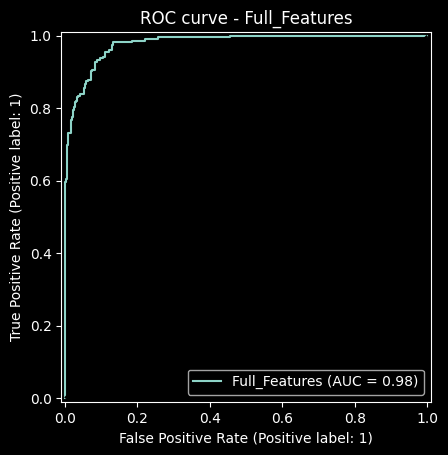

<Figure size 800x600 with 0 Axes>

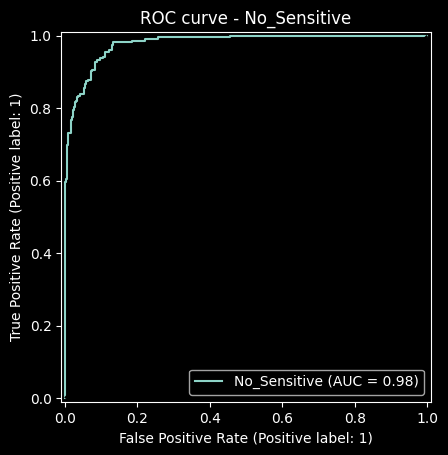

<Figure size 800x600 with 0 Axes>

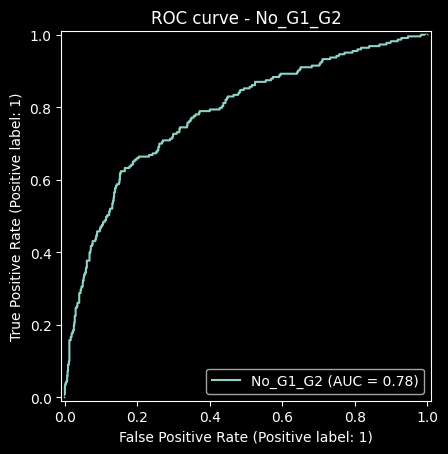

In [150]:
# Initialize context and orchestrator
from core.pipeline_core.pipeline_builder import PipelineBuilder


orchestrator = PipelineOrchestrator()
context = PipelineContext()

# Build pipeline from Notebook classes and YAML config
pipeline = PipelineBuilder.build_from_yaml("pipeline_config.yaml", orchestrator)

# Run the pipeline
try:
    final_context = orchestrator.run(context)
except Exception as e:
    logger.error(f"❌ Pipeline failed: {e}")
finally:
    print("🏁 Pipeline execution ended.")
    
    # Final report
    print("\n--- Merged datas overview ---")
    display(final_context.final_df.head())

    print("\n--- Execution stats ---")
    for step, duration in final_context.execution_time.items():
        print(f"{step:25} : {duration:.4f}s")



## Store the best run

Prepare API exporting the best model (based uppon AUC)

In [151]:
import joblib
import mlflow

# Get the best model from MLFlow tracking (based on AUC score)
runs = mlflow.search_runs(order_by=["metrics.auc_score DESC"])
best_run_id = runs.iloc[0]['run_id']

# Load and save the best model locally
best_model = mlflow.sklearn.load_model(model_uri=f"runs:/{best_run_id}/model")
joblib.dump(best_model, "backend/models/student_model_auc_latest.joblib")
print(f"✅ Best model based on AUC score was saved successfully : {runs.iloc[0]['tags.mlflow.runName']}")

# Get the best model from MLFlow tracking (based on Accuracy score)
runs = mlflow.search_runs(order_by=["metrics.accuracy DESC"])
best_run_id = runs.iloc[0]['run_id']

# Load and save the best model locally
best_model = mlflow.sklearn.load_model(model_uri=f"runs:/{best_run_id}/model")
joblib.dump(best_model, "backend/models/student_model_accuracy_latest.joblib")
print(f"✅ Best model based on Accuracy score was saved successfully : {runs.iloc[0]['tags.mlflow.runName']}")

✅ Best model based on AUC score was saved successfully : LR_No_Sensitive
✅ Best model based on Accuracy score was saved successfully : RF_No_Sensitive
